# QeMCMC Tutorial

Here we assume you have set up your python environment, with the latest version of qemcmc (0.1 at time of writing) and its requirements.

## Imports

In [6]:
# Import necessary libraries
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

# Import the required classes from QeMCMC

# QeMCMC class contains the main functionality for the classical MCMC simulation
from qemcmc.ClassicalMCMC import ClassicalMCMC

# QeMCMC class contains the main functionality for the quantum enhanced MCMC simulation
from qemcmc.QeMCMC_ import QeMCMC

# These are object useful to store the results of the MCMC simulation
from qemcmc.helpers import plot_chains

# This helps you build an example Ising model
from qemcmc.ModelMaker import ModelMaker



## Define model problem and algorithm parameters

In [7]:

# Define parameters
n = 7 # Number of spins in the system
reps = 20 # How many markov chains to produce
steps = 100 # Length of each markov chain
temp = 0.1 # Temperature of the system


# QeMCMC parameters
gamma = (0.3,0.6)# Relative strength of mixer hamiltonian 
time = (1,10) # Time for hamiltonian simulation

# Build an Ising model to test the algorithms on
model_type = "Fully Connected Ising"
name = "Test Ising model"
model = ModelMaker(n, model_type, name).model
initial_states = model.initial_state


## Run classical MCMC

In [8]:

# Run classical (uniform and local) chains

uni_chains = []
for rep in range(reps):
    classical_uniform_MCMC = ClassicalMCMC(model, temp, method = "uniform")
    uni_chain = classical_uniform_MCMC.run(steps, initial_state = initial_states[rep], name = "classical uniform MCMC", verbose = False, sample_frequency = 1)
    uni_chains.append(uni_chain)


loc_chains = []
for rep in range(reps):
    classical_local_MCMC = ClassicalMCMC(model, temp, method = "local")
    loc_chain = classical_local_MCMC.run(steps, initial_state = initial_states[rep], name = "classical local MCMC", verbose = False, sample_frequency = 1)
    loc_chains.append(loc_chain)




## Run quantum MCMC

In [9]:
# Run the quantum algorithm
# The QeMCMC class is very similar to the MCMC class, but it has a few extra parameters that are specific to the quantum algorithm. 
# gamma and time are the hyperparameters that might need tuned for your specific problem.
# This may take a minute or so to run, depending on the number of steps and the size of the system. (takes 40s on my system for the default settings)

def run_qemcmc(rep):
    quantum_MCMC = QeMCMC(model, gamma=gamma, time=time, temp=temp)
    return quantum_MCMC.run(steps, initial_state=initial_states[rep], name="QeMCMC", verbose=True, sample_frequency=1)

# Run in parallel as they can take a while.
Qe_chains = Parallel(n_jobs=-1)(delayed(run_qemcmc)(rep) for rep in range(reps))
    

## Analysis

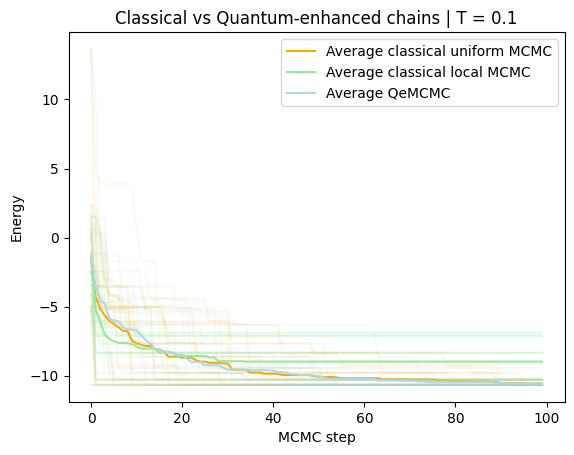

In [10]:
# Plot the list of chains with a helper function
# Dark line is for average ove rchains, transparenr lines are for each individual chains

plot_chains(uni_chains, "orange", "classical uniform MCMC")
plot_chains(loc_chains, "lightgreen", "classical local MCMC")
plot_chains(Qe_chains, "lightblue", "QeMCMC")

plt.xlabel("MCMC step")
plt.ylabel("Energy")
plt.title("Classical vs Quantum-enhanced chains | T = {}".format(temp))
plt.legend()
plt.show()

## Convergence
Hopefully it should be clear that fewer of the quantum-enhanced chains get stuck in local minima, and are able to fully traverse the state space. This results in the average energy across multiple chains reaching the stationary distribution earlier than the classical local proposal. Of course, chains may look like they have thermalised, however they are actually stuck in non-global minima.

## Temperature dependence

The QeMCMC is much more effective at lower temperatures so changing the initial temperature should result in different outcomes. Have a play with the temperature parameter and see how it affects convergence. For low temperatures T<0.1, local classical chains are highly likely to get stuck in local minima and only converge to the stationary distribution extremely slowly.

## Size dependence

The difficulty of the sampling problem is exponentially related to the size of the Ising model. Play with the size of the system and see how the problem becomes difficult. Also change the number of qubits used and see how the quantum method improves with more qubits.

## Random nature of MCMC

Please note that to gain a true insight into the efficacy of these methods, one needs to average over many different chains, on many different model instances. Some model instances are naturally much harder and some random starting positions are lucky - they are close to the global minima. This means that the simple experiment above may give unreliable results, but if you run it enough times, a clear trend should be clear.

# Spectral Gap calculation

The package also comes with inbuilt functionality to calculate the spectral gap of each proposal method.

The spectral gap is a very good measure of the convergance capabilities of a given Markov Chain. It is inversely proportional to the thermalisation time, so studying the average spectral gap of many chains (on many models) can allow us to compare classical and quantum methods


In [11]:
from qemcmc.spectralgap import SpectralGap
from tqdm.notebook import tqdm

# Define parameters of experiment
temp = 0.1
n_list = [2,3,4,5,6]

# Number of models to test at each n
number_of_models = 15

# Type of model to test
model_type = "Fully Connected Ising"


q_spec_gaps = []
uni_spec_gaps = []
loc_spec_gaps = []



# Loop over the number of spins in the system
pbar = tqdm(n_list, desc="Looping through n", bar_format = "{l_bar}|{bar}| {n_fmt}/{total_fmt}{postfix}")
for n in pbar:
    pbar.set_description(f"Currently on system size, n: {n}")

    q_spec_gaps_n = []
    uni_spec_gaps_n = []
    loc_spec_gaps_n = []
    # Loop over the number of models to test
    
    pbar_2 = tqdm(list((range(number_of_models))), total=number_of_models, desc="Looping through models")
    for i in pbar_2:
        pbar_2.set_description(f"Looping through models, currently on number: {i+1}")
        
        # Build an Ising model to test the algorithms on
        model = ModelMaker(n, model_type, None).model
        initial_states = model.initial_state
        
        # Run classical (uniform and local) chains
        classical_uniform_MCMC = ClassicalMCMC(model, temp, method = "uniform")
        spec_gap_finder = SpectralGap(classical_uniform_MCMC)
        uni_spec_gaps_n.append(spec_gap_finder.find_spec_gap())
        
        classical_local_MCMC = ClassicalMCMC(model, temp, method = "local")
        spec_gap_finder = SpectralGap(classical_local_MCMC)
        loc_spec_gaps_n.append(spec_gap_finder.find_spec_gap())
        
        # Run the quantum algorithm
        quantum_MCMC = QeMCMC(model, temp =temp, gamma=(0.3,0.6), time=(2,10))
        spec_gap_finder = SpectralGap(quantum_MCMC)
        q_spec_gaps_n.append(spec_gap_finder.find_spec_gap())
    
    # Append the results to the list
    uni_spec_gaps.append(np.mean(uni_spec_gaps_n))
    loc_spec_gaps.append(np.mean(loc_spec_gaps_n))
    q_spec_gaps.append(np.mean(q_spec_gaps_n))
    
    
    
    


Looping through n:   0%||          | 0/5

Looping through models:   0%|          | 0/15 [00:00<?, ?it/s]

Looping through models:   0%|          | 0/15 [00:00<?, ?it/s]

Looping through models:   0%|          | 0/15 [00:00<?, ?it/s]

Looping through models:   0%|          | 0/15 [00:00<?, ?it/s]

Looping through models:   0%|          | 0/15 [00:00<?, ?it/s]

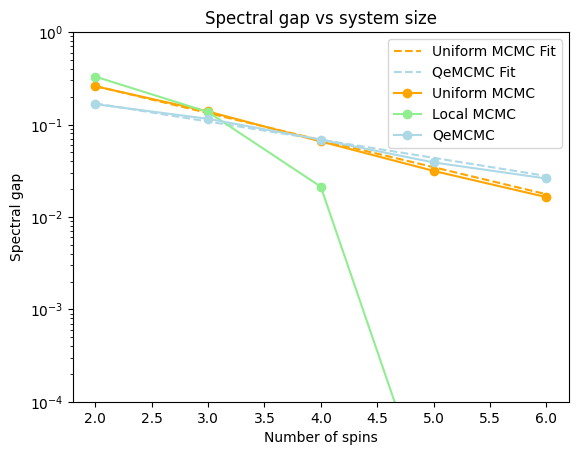

Uniform MCMC fit parameters:  [1.00558292 0.67417004]
Local MCMC fit parameters:  [2.73139202 1.05080311]
QeMCMC fit parameters:  [0.41797697 0.451985  ]


In [ ]:
from scipy.optimize import curve_fit
import numpy as np

# Define the exponential decay function
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

# Fit the uniform MCMC data
uni_params, _ = curve_fit(exp_decay, n_list, uni_spec_gaps)
plt.plot(n_list, exp_decay(np.array(n_list), *uni_params), linestyle='--', label="Uniform MCMC Fit", color = "orange")

# Fit the local MCMC data
loc_params, _ = curve_fit(exp_decay, n_list, loc_spec_gaps)
#plt.plot(n_list, exp_decay(np.array(n_list), *loc_params), linestyle='--', label="Local MCMC Fit", color = "lightgreen")

# Fit the QeMCMC data
q_params, _ = curve_fit(exp_decay, n_list, q_spec_gaps)
plt.plot(n_list, exp_decay(np.array(n_list), *q_params), linestyle='--', label="QeMCMC Fit", color = "lightblue")




# Plot results
plt.plot(n_list, uni_spec_gaps, marker='o', label = "Uniform MCMC", color = "orange")
plt.plot(n_list, loc_spec_gaps, marker='o', label = "Local MCMC", color = "lightgreen")
plt.plot(n_list, q_spec_gaps, marker='o', label = "QeMCMC", color = "lightblue")

plt.legend()
plt.xlabel("Number of spins")
plt.ylabel("Spectral gap")
plt.title("Spectral gap vs system size")
plt.yscale("log")
plt.ylim(1e-4, 1e0)
plt.show()


print("Uniform MCMC fit parameters: ", uni_params)
print("Local MCMC fit parameters: ", loc_params)
print("QeMCMC fit parameters: ", q_params)
